In [1]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
figformat = 'png'

In [3]:
dataset_asimov = Dataset_load.create_asimov(source = "PKSflare", model = 'pl')


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


In [4]:
source = dataset_asimov.models[0].name
geom = dataset_asimov.exposure.geom
coords = geom.get_coord(sparse=True)
rad = coords.skycoord.separation(geom.center_skydir)
rad.shape

(1, 500, 500)

In [5]:
from gammapy.irf import PSFMap, PSFKernel

def create_gaussian(psf, sigma, rad = dataset_asimov.psf.psf_map.geom.axes['rad'],
                   geom = dataset_asimov.psf.psf_map.geom.to_image()):

    psf_map_g = PSFMap.from_gauss(energy_axis_true = psf.psf_map.geom.axes['energy_true'],
                        sigma = sigma*u.deg,
                          geom =geom ,
                          rad_axis = rad,
                         )
    
    psf_kernel_g = psf_map_g.get_psf_kernel(dataset_asimov.exposure.geom)
    psf_kernel_g.to_image().psf_kernel_map.reproject_to_geom(geom, preserve_counts=True).plot(ax=None, add_cbar=1)
    return psf_map_g, psf_kernel_g

from astropy.visualization import quantity_support
from matplotlib.ticker import FormatStrFormatter
def plot_psf_vs_rad(psf, ax=None, energy_true=[0.1, 1, 10] * u.TeV,energy_name='energy', label = None,**kwargs):
    """Plot PSF vs radius.

    The method plots the profile at the center of the map.

    Parameters
    ----------
    ax : `~matplotlib.pyplot.Axes`
        Axes to plot on.
    energy : `~astropy.units.Quantity`
        Energies where to plot the PSF.
    **kwargs : dict
        Keyword arguments pass to `~matplotlib.pyplot.plot`.

    Returns
    -------
    ax : `~matplotlib.pyplot.Axes`
         Axes to plot on.

    """
    ax = plt.gca() if ax is None else ax

    rad = psf.psf_map.geom.axes["rad"].center

    for value in energy_true:
        psf_value = psf.psf_map.interp_by_coord(
            {
                "skycoord": psf.psf_map.geom.center_skydir,
                energy_name: value,
                "rad": rad,
            }
        )
        #if label is None:
        label_ = f"{value}" +label
        with quantity_support():
            ax.plot(rad**2, psf_value, label=label_, **kwargs)

    ax.set_yscale("log")
    ax.set_xlabel(f"Rad **2  ({ax.xaxis.units})")
    ax.set_ylabel(f"PSF ({ax.yaxis.units})")
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.legend()
    return ax


## Understanding the PSFMap

Text(0.5, 1.0, 'True PSF Kernel')

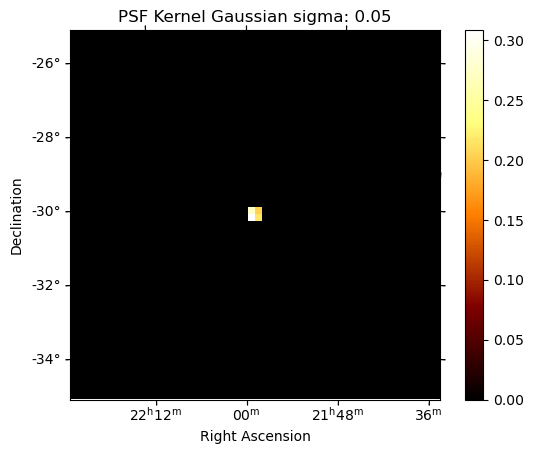

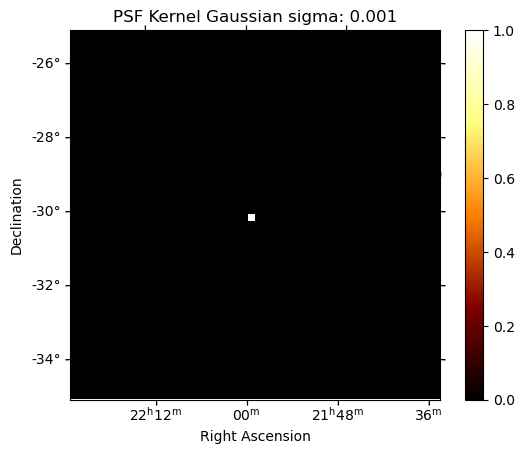

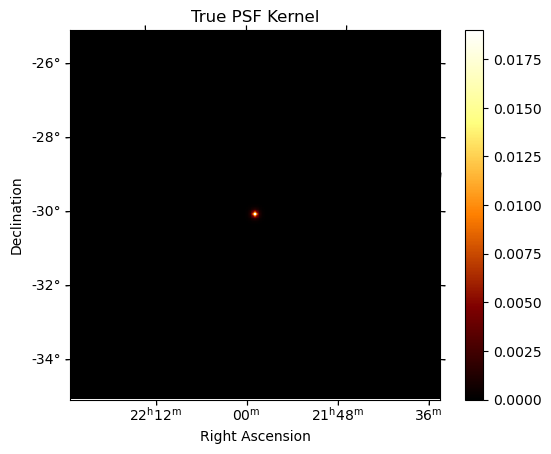

In [6]:
value_g = 0.05
value_g_2 = 1e-3
plt.figure()
psf_map_g, psf_kernel_g = create_gaussian(dataset_asimov.psf,value_g)
ax = plt.gca()
ax.set_title(f"PSF Kernel Gaussian sigma: {value_g}")

plt.figure()
psf_map_g_2, psf_kernel_g_2 = create_gaussian(dataset_asimov.psf,value_g_2)
ax = plt.gca()
ax.set_title(f"PSF Kernel Gaussian sigma: {value_g_2}")

plt.figure()
psf_map = dataset_asimov.psf
#(geom, position=None, max_radius=None, containment=0.999, factor=4)
psf_kernel = psf_map.get_psf_kernel(dataset_asimov.exposure.geom)
#psf_kernel.to_image().psf_kernel_map.sum_over_axes().plot(ax=None, add_cbar=1)
psf_kernel.to_image().psf_kernel_map.reproject_to_geom(geom.to_image(), preserve_counts=True).plot(ax=None, add_cbar=1)

ax = plt.gca()
ax.set_title(f"True PSF Kernel")

<Axes: xlabel='Rad **2  (deg2)', ylabel='PSF (None)'>

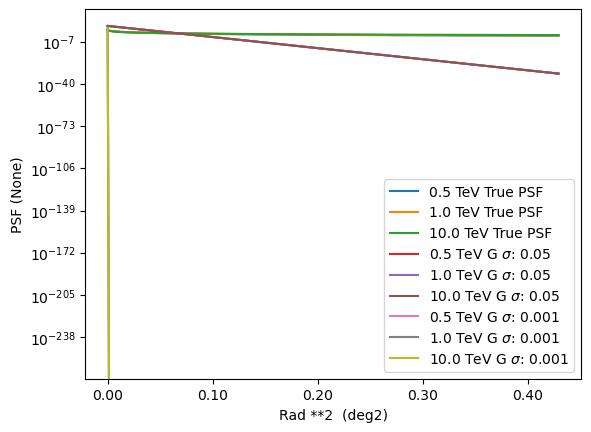

In [7]:
plot_psf_vs_rad(psf_map, ax=None, energy_true=[0.5, 1, 10] * u.TeV,energy_name='energy_true', label = " True PSF")
plot_psf_vs_rad(psf_map_g, ax=None, energy_true=[0.5, 1, 10] * u.TeV,energy_name='energy_true', label = f" G $\sigma$: {value_g}")
plot_psf_vs_rad(psf_map_g_2, ax=None, energy_true=[0.5, 1, 10] * u.TeV,energy_name='energy_true', label = f" G $\sigma$: {value_g_2}")



### 
### In Mapdataset:

psf: psfPSFMap or HDULocation

    PSF kernel
    
    

### 
### where the psfPSFMap:

class gammapy.irf.PSFMap(psf_map, exposure_map=None)[source]

Bases: gammapy.irf.core.IRFMap

Class containing the Map of PSFs and allowing to interact with it.

Parameters

    psf_mapMap

        the input PSF Map. Should be a Map with 2 non spatial axes. rad and true energy axes should be given in this specific order.
    exposure_mapMap

        Associated exposure map. Needs to have a consistent map geometry.



### 
### However the PSFKernel:
class gammapy.irf.PSFKernel(psf_kernel_map, normalize=True)[source]

Bases: object

PSF kernel for Map.

This is a container class to store a PSF kernel that can be used to convolve WcsNDMap objects. It is usually computed from an PSFMap.

Parameters

    psf_kernel_mapMap

        PSF kernel stored in a Map



### From Map to Kernel:


psf = PSFMap.from_gauss(
    energy_axis_true=energy_axis_true, sigma=[0.3, 0.2, 0.1] * u.deg
)

kernel = psf.get_psf_kernel(geom=geom, max_radius=1*u.deg)

This function is used in the evaluator class in ``update``! With the exposure geom (most cases)

``self.psf = psf.get_psf_kernel( position=self.model.position, geom=geom_psf, containment=PSF_CONTAINMENT, max_radius=PSF_MAX_RADIUS,) ``


## Model prediction

Text(0.5, 1.0, 'npred true PSF')

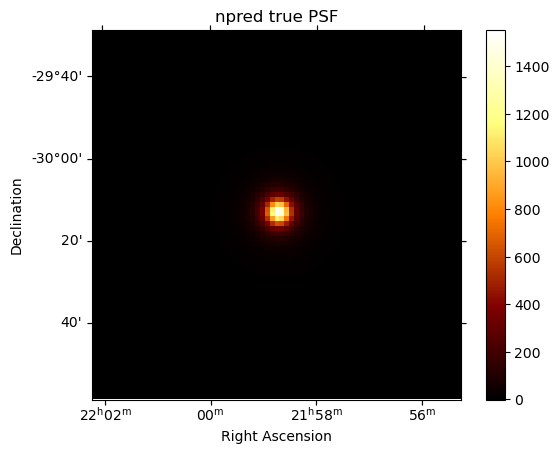

In [8]:
evalu = dataset_asimov.evaluators[dataset_asimov.models[0].name]

evalu.update(exposure= dataset_asimov.exposure
        , psf=dataset_asimov.psf
        , edisp= dataset_asimov.edisp
        , geom= dataset_asimov.geoms['geom']
        , mask= dataset_asimov.mask)
npred= evalu.compute_npred()
npred.sum_over_axes().plot(add_cbar= 1)
plt.title("npred true PSF")

In [9]:
psf_kernel_conv = psf_kernel.psf_kernel_map.convolve(psf_kernel_g)

evalu.update(exposure= dataset_asimov.exposure
        , psf=PSFKernel(psf_kernel_map = psf_kernel_conv)
        , edisp= dataset_asimov.edisp
        , geom= dataset_asimov.geoms['geom']
        , mask= dataset_asimov.mask)
npred_g= evalu.compute_npred().reproject_to_geom(npred.geom, preserve_counts=True) 
npred_g.sum_over_axes().plot(add_cbar= 1)
plt.title("npred gaussian PSF")

AttributeError: 'PSFKernel' object has no attribute 'energy_name'

In [ ]:
psf_kernel_conv_2 = psf_kernel.psf_kernel_map.convolve(psf_kernel_g_2)

evalu.update(exposure= dataset_asimov.exposure
        , psf=PSFKernel(psf_kernel_map = psf_kernel_conv_2)
        , edisp= dataset_asimov.edisp
        , geom= dataset_asimov.geoms['geom']
        , mask= dataset_asimov.mask)
npred_g_2= evalu.compute_npred().reproject_to_geom(npred.geom, preserve_counts=True) 
npred_g_2.sum_over_axes().plot(add_cbar= 1)
plt.title("npred gaussian PSF")

In [ ]:

diff =  npred - npred_g
ex = np.max(np.abs(diff.data))
diff.sum_over_axes().plot(add_cbar = 1,cmap = 'coolwarm', vmin  = -ex, vmax = ex)
plt.title(f"Absolute difference {value_g}")    

In [ ]:

diff_2 =  npred - npred_g_2
ex = np.max(np.abs(diff_2.data))
diff_2.sum_over_axes().plot(add_cbar = 1,cmap = 'coolwarm', vmin  = -ex, vmax = ex)
plt.title(f"Absolute difference {value_g_2}")    

NameError: name 'npred' is not defined

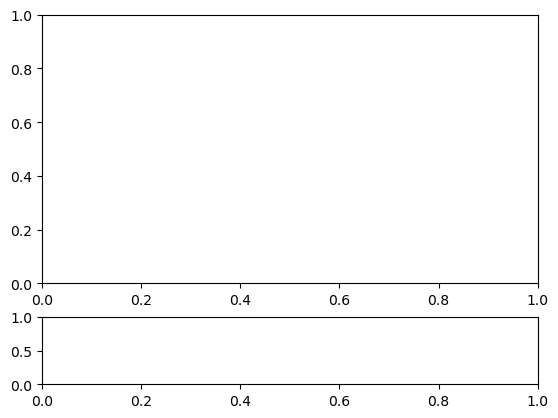

In [7]:
fig,(ax1, ax2) = plt.subplots(2,1 ,height_ratios=[4,1])
e_idx = 14 
ax1.plot(npred.data[e_idx,:,:].sum(axis=1), label  = 'true         ' + str(np.sum(npred.data)))
ax1.plot(npred_g.data[e_idx,:,:].sum(axis=1), label  = f'G {value_g}     ' + str(np.sum(npred_g.data)))
ax1.plot(npred_g_2.data[e_idx,:,:].sum(axis=1), label  = f'G {value_g_2}   ' + str(np.sum(npred_g_2.data)), 
        linestyle= 'dashed')
ax1.legend()
ax1.set_title("summed along ra")    

ax2.plot(diff.data[10,:,:].sum(axis=1), label  = f'Gaussian conv {value_g}')
ax2.plot(diff_2.data[10,:,:].sum(axis=1), label  = f'Gaussian conv {value_g_2}')

